In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

import scipy

from itertools import combinations

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

import os
import sys

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools



# sns.set_style('dark')
# sns.set_style('ticks')
# plt.style.use('dark_background')

In [87]:
condition_properties = {
#                     'Evo1D_IRAs':{1:[0,1,4,7,10,13,16,19,22,24],
#                                       2:[0,1,4,7,10,13,16,19,22,24]},
#                         'Evo1D_TCG':{1:[0,1,4,8,10,13,16,19,22,24],
#                                     2:[0,1,4,8,10,13,16,19,22,24]},
                        
                        
                        'Evo2D_Ira1_Mis':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]
                                         },
                        'Evo2D_Ira1_Non':{1:[0,1,4,7,10,13,17,21,25],
                                         2:[0,1,4,7,10,13,17,21,25]},
                        
                        'Evo2D_CYR1':{1:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 128, 136, 144, 152, 160]},
                        'Evo2D_GPB2':{1:[0, 8, 32, 56, 64, 80, 104, 120],
                                         2:[0, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 136, 144, 160]},
                        'Evo2D_TOR1':{1:[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160],
                                         2:[0, 16, 24, 40, 48, 64, 72, 88, 104, 112, 120, 128, 136, 152, 160]},                        
  
                        
#                         'Evo3D_Ira1_Mis':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21],
#                                          3:[0,1,4,7,10,14,17,21]},
#                         'Evo3D_Ira1_Non':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21],
#                                          3:[0,1,4,7,10,14,17,21]},
                        
#                         'Evo3D_TCG':{1:[0,1,4,7,10,14,17,21],
#                                          2:[0,1,4,7,10,14,17,21]},               
                       }

aggeli_conditions = {'Evo2D_CYR1':'Cyr1Evo',
                     'Evo2D_GPB2':'Gpb2Evo',
                     'Evo2D_TOR1':'Tor1Evo'
                    }


n_gens = 8
effective_n = 6 * 10**8 

cov_thresh = 1e5

In [88]:

mean_fitness_dict = {}

evolution_fitness_dict = {}

for condition,reps in condition_properties.items():
    
    all_samples = []
    
    if condition not in aggeli_conditions.keys():
        this_data = p.read_csv(f'{condition}_counts_curated.csv')
#         all_samples = []
        for rep,timepoints in reps.items():
            for time in timepoints:
                if time == 0:
                    all_samples.append(f'{condition}_0_0_count')
                else:
                    all_samples.append(f'{condition}_{rep}_{time}_count')
                    
        this_data['barcode'] = this_data['fused_bc']
        
    elif condition in aggeli_conditions.keys():
        this_data = p.read_csv(f'{home_dir}/EvolutionTracking/Aggeli2021_data/{aggeli_conditions[condition]}{rep}_CountsTimecourse.txt',sep='\t')
        this_data['barcode'] = [f'{bc.split("_")[1]}_{bc.split("_")[0]}' for bc in this_data['BC'].values]
#         for time in timepoints:
#             if np.sum(this_data[str(time)]) > cov_thresh:
# #                 used_timepoints.append(time)
#                 all_samples.append(str(time))

    
        

    this_fit_mut = p.read_csv(f'FitMut2_processing/out_fitmut1_thresholded/{condition}_{rep}_MutSeq_Result.csv')

    mean_fitness = this_fit_mut['Mean_Fitness'].values
    mean_fitness = mean_fitness[~np.isnan(mean_fitness)]

    mean_fitness_dict[f'{condition}_{rep}'] = mean_fitness

    kappas = this_fit_mut['Kappa_Value'].values
    kappas = kappas[~np.isnan(kappas)]


    mutant_cell_fraction = this_fit_mut['Mutant_Cell_Fraction'].values
    mutant_cell_fraction = mutant_cell_fraction[~np.isnan(mutant_cell_fraction)]

    this_fit_mut = this_fit_mut[['Fitness','Establishment_Time','Error_Fitness','Error_Establishment_Time','Likelihood_Log_Adaptive']]
#         this_fit_mut = this_fit_mut[['Fitness','Establishment_Time','Error_Fitness','Error_Establishment_Time','Probability_Adaptive']]
    this_fit_mut['barcode'] = this_data['barcode'] 

    for bc,fitness in zip(this_fit_mut['barcode'].values,this_fit_mut['Fitness'].values):
        if bc in evolution_fitness_dict:
            evolution_fitness_dict[bc][0].append(fitness)
            evolution_fitness_dict[bc][1].append(f'{condition}_R{rep}')

        else:
            evolution_fitness_dict[bc] = [[fitness],[f'{condition}_R{rep}']]



In [89]:
evolution_fitness_dict

{'CATTGAATCACAAAATAGGTTAGATG_TTATCAAAAATGAAGTAAGTTAGGAT': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'CATTGAATCACAAAATAGGTTAGATG_GGCACAAGATTGAAATCGATTATACT': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_TAGGCAATTACCAATCATGTTACGAT': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_ACACAAAATTGGAATACTTTTCGACA': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_CTAGGAAACGTGAATGCTTTTCTTAG': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_CCGTAAAACCCAAAGATCGTTGAATG': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_TACAGAAGTGTAAAGTCAGTTTTAAG': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_CATCGAACAAGAAAGGAGGTTGCGCT': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_TACATAAAGAGCAATACTCTTATTAA': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_AACCCAAAGAGTAACAATTTTATCCG': [[0.0],
  ['Evo2D_Ira1_Mis_R2']],
 'TGATCAATCTACAAAAATATTTAATG_GTGAAAAAAGACAAATGTCTTAATCA': [[0.0],
  ['Evo2D_Ira1

In [90]:
home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
# home_dir = os.path.expanduser(home_dir)
rearray_map = p.read_csv(f'{home_dir}/data/BenomylTest/EvolvingFront_rearray_map_with_ploidy.csv')

remeasurement_data = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)

In [91]:
evolution_fitness_values = {}
evolution_fitness_conditions = {}
evolution_fitness_all = {}

for bc,condition_sets in evolution_fitness_dict.items():
    fs = condition_sets[0]
    conditions = condition_sets[1]
    if bc in remeasurement_data['barcode'].values:
        use_condition_of_origin = False
        evo_cond = remeasurement_data[remeasurement_data['barcode']==bc]['evolution_condition'].values[0]
        cloneID = remeasurement_data[remeasurement_data['barcode']==bc]['cloneID_new'].values[0]
        if cloneID in rearray_map['destination_well'].values:
            use_condition_of_origin = True
            condition_of_origin = rearray_map[rearray_map['destination_well']==cloneID]['source_well'].values[0]
            condition_of_origin = '_'.join(condition_of_origin.split('_')[:-2])
#             print(condition_of_origin)

        fs_filtered = []
        conditions_filtered = []
        for f,cond in zip(fs,conditions):
            if use_condition_of_origin:
                if condition_of_origin == cond.upper():
                    fs_filtered.append(f)
                    conditions_filtered.append(cond)
#                     print('here',condition_of_origin,cond)
            else:
                if evo_cond in cond:
                    fs_filtered.append(f)
                    conditions_filtered.append(cond)

        if not np.any(fs_filtered): # if they are all 0
            evolution_fitness_values[bc] = np.nan
            evolution_fitness_conditions[bc] = np.nan
        else:
#             if np.count_nonzero(fs_filtered) > 1:
#                 print(bc,fs_filtered,conditions_filtered)
#                 print(remeasurement_data)
#             if bc == 'TGATCAATCTACAAAAATATTTAATG_ACGACAATCTCGAATAGGTTTTTCTG': # this barcode has very high fitness in one replicate that's unrealisitic
#                 entry = np.where(fs_filtered==np.min(fs_filtered))[0][0]
#                 evolution_fitness_values[bc] = fs_filtered[entry]
# #                 evolution_fitness_conditions[bc] = conditions_filtered[entry]
#             else:
            evolution_fitness_all[bc] = {condition:f for condition,f in zip(conditions_filtered,fs_filtered)}
            entry = np.where(fs_filtered==np.max(fs_filtered))[0][0]
            evolution_fitness_values[bc] = fs_filtered[entry]
            evolution_fitness_conditions[bc] = conditions_filtered[entry]

In [92]:
home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
# home_dir = os.path.expanduser(home_dir)
rearray_map = p.read_csv(f'{home_dir}/data/BenomylTest/EvolvingFront_rearray_map_with_ploidy.csv')

remeasurement_data = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)

evolution_fitness = []
evolution_conditions = []

bcs_isolated_here = []
for bc,cloneID in zip(remeasurement_data['barcode'].values,remeasurement_data['cloneID_new'].values):
    
    if bc in evolution_fitness_values.keys():
        evolution_fitness.append( evolution_fitness_values[bc])
        evolution_conditions.append( evolution_fitness_conditions[bc])
    else:
        evolution_fitness.append(np.nan)
        evolution_conditions.append(np.nan)


remeasurement_data['evolution_fitness'] = evolution_fitness
remeasurement_data['isolated_evolution_condition'] = evolution_conditions
        
# overlapping_bcs = [bc for bc in this_data['barcode'].values if bc in isolated_here['barcode'].values]

In [93]:

# set_to_plot = remeasurement_data[(remeasurement_data['ancestor']=='IRA1_MIS') & 
#                    (remeasurement_data['class_new']=='adaptive_haploid') & 
#                                 (remeasurement_data['evolution_condition']=='Evo2D')]


set_to_plot = remeasurement_data[
#                     (remeasurement_data['ancestor']=='IRA1_MIS') & 
                   (remeasurement_data['class_new']=='adaptive_haploid') & 
                                (remeasurement_data['evolution_condition']=='Evo2D')]
#                    (remeasurement_data['gene'].isin(['CIT1','KGD1','MDH1','RTG2','ARO80','GSH1']))
#                                 ]



In [94]:
set_to_plot

,Fit1D-2%-R1_fitness,Fit1D-2%-R1_error,Fit1D-2%-R2_fitness,Fit1D-2%-R2_error,Fit1D-5%-R1_fitness,Fit1D-5%-R1_error,Fit1D-5%-R2_fitness,Fit1D-5%-R2_error,Fit2D-2%-R1_fitness,Fit2D-2%-R1_error,...,Fit2D_both2%5%_fitness_relative,Fit2D_both2%5%_fitness_ancestor,Fit2D_early_fitness_relative,Fit2D_early_fitness_ancestor,Fit3D_early_fitness_relative,Fit3D_early_fitness_ancestor,Fit5D_early_fitness_relative,Fit5D_early_fitness_ancestor,evolution_fitness,isolated_evolution_condition
1,0.938763,0.035535,1.009834,0.036124,0.936852,0.024449,0.940881,0.024295,1.721427,0.024800,...,1.042312,0.624987,1.888121,1.497699,2.667791,0.846150,2.526322,0.547042,0.054041,Evo2D_GPB2_R2
3,1.074590,0.049368,1.048208,0.050017,0.913976,0.039413,0.963205,0.035169,1.364335,0.032921,...,0.475804,0.901522,0.926555,1.553199,2.378539,-0.844753,1.924667,-1.905910,NaN,NaN
11,0.954536,0.048001,1.016103,0.047771,0.975953,0.034040,0.983339,0.030787,1.380704,0.029268,...,0.518183,0.901522,1.235137,1.553199,2.185454,-0.844753,-1.509793,-1.905910,0.063572,Evo2D_Ira1_Non_R2
17,0.985532,0.037513,0.960673,0.038194,0.801245,0.025972,0.885304,0.025508,1.564788,0.025966,...,0.914811,0.641719,1.874507,1.564134,2.473457,0.914799,2.760513,0.481995,0.437645,Evo2D_CYR1_R2
20,0.511181,0.187293,0.541756,0.164726,0.551866,0.091231,0.461282,0.072901,1.402412,0.036903,...,0.532484,0.901522,0.663298,1.553199,2.118099,-0.844753,0.390889,-1.905910,0.075229,Evo2D_Ira1_Non_R2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959,2.059598,0.241756,0.747945,0.184822,0.350479,0.160900,0.409983,0.159029,0.398892,0.315192,...,0.359326,0.000000,0.290578,0.000000,-0.303907,0.000000,-0.676511,0.000000,NaN,NaN
4982,0.613519,0.165061,0.627840,0.192093,0.721715,0.131600,0.557184,0.114920,0.755782,0.171871,...,0.689655,0.000000,1.123674,0.000000,0.496977,0.000000,-1.315578,0.000000,NaN,NaN
4987,0.565860,0.096155,0.651235,0.098367,0.552731,0.071922,0.567498,0.057465,0.616294,0.132032,...,0.584273,0.000000,1.460944,0.000000,0.587150,0.000000,0.309251,0.000000,NaN,NaN
5004,1.107639,0.056887,1.162029,0.060838,1.006517,0.043387,1.102517,0.037567,1.092998,0.060551,...,0.438916,0.641719,0.959902,1.564134,1.029052,0.914799,0.601126,0.481995,0.071520,Evo2D_CYR1_R2


In [95]:

evolution_fitness_all

{'CATTGAATCACAAAATAGGTTAGATG_CTAAAAACCTTAAATTAATTTCAAAT': {'Evo2D_Ira1_Mis_R2': 0.0428227913742537},
 'CATTGAATCACAAAATAGGTTAGATG_TGTTAAACCCATAAATTCGTTTGGCG': {'Evo2D_Ira1_Mis_R2': 0.0479157797373039},
 'CATTGAATCACAAAATAGGTTAGATG_CGGTAAACGGGAAACTTGCTTGGGGC': {'Evo2D_Ira1_Mis_R2': 0.0462686739544508},
 'CATTGAATCACAAAATAGGTTAGATG_AATCTAACTTTGAAGGTTATTAATTT': {'Evo2D_Ira1_Mis_R2': 0.0437632761864294},
 'TGATCAATCTACAAAAATATTTAATG_GGGCGAAACTGCAAGGCAGTTAGGCG': {'Evo2D_Ira1_Mis_R2': 0.0481690693292577},
 'CATTGAATCACAAAATAGGTTAGATG_AACGAAAGTTCCAACTACTTTTGAAT': {'Evo2D_Ira1_Mis_R2': 0.0305628917870283},
 'TGATCAATCTACAAAAATATTTAATG_CCGGGAAGAAAGAAACGGATTACTAG': {'Evo2D_Ira1_Mis_R2': 0.0569522108230221},
 'TGATCAATCTACAAAAATATTTAATG_GCCTGAATCTTTAAGCCGTTTAGGGA': {'Evo2D_Ira1_Mis_R2': 0.0532558343398763},
 'TGATCAATCTACAAAAATATTTAATG_ATTACAACTCATAAGAATGTTTTGCG': {'Evo2D_Ira1_Mis_R2': 0.0447172331380674},
 'TGATCAATCTACAAAAATATTTAATG_TTAGCAAAACTAAACTTACTTATAAA': {'Evo2D_Ira1_Mis_R2': 0.045802905

In [165]:
fitness = 'Fit2D_both2%5%_fitness'
fitness = 'Fit2D_early_fitness'


# set_to_plot = remeasurement_data[(remeasurement_data['ancestor'].isin(['IRA1_MIS','IRA1_NON'])) & 
#                    (remeasurement_data['class_new'].isin(['adaptive_haploid','high_fitness_diploids'])) & 
#                                 (remeasurement_data['evolution_condition']=='Evo2D')]


set_to_plot = remeasurement_data[
                    (remeasurement_data['ancestor'].isin(['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'])) & 
                   (remeasurement_data['class_new'].isin(['adaptive_haploid','high_fitness_diploids'])) & 
                                (remeasurement_data['evolution_condition']=='Evo2D')]

set_to_plot = set_to_plot[~p.isnull(set_to_plot['evolution_fitness'].values)]


# exclude two outlier CYR1 mutants with very high inferred evolution fitness
set_to_plot =  set_to_plot[set_to_plot['evolution_fitness'] < 0.2]


# this_df = p.DataFrame(
#                      {'barcode':set_to_plot['barcode'],
#                       'evolution_fitness':overlap_evo['Fitness'].values,
#                       'remeasured_fitness':overlap_fit[fitness].values-ancestor_fit,
#                       'FerPerHour_relative':overlap_fit['FerPerHour_relative'].values,
#                       'ResPerHour_relative':overlap_fit['ResPerHour_relative'].values})

In [166]:
import pingouin as pg

In [167]:
# 

set_to_plot[set_to_plot['ancestor'] =='CYR1']

,Fit1D-2%-R1_fitness,Fit1D-2%-R1_error,Fit1D-2%-R2_fitness,Fit1D-2%-R2_error,Fit1D-5%-R1_fitness,Fit1D-5%-R1_error,Fit1D-5%-R2_fitness,Fit1D-5%-R2_error,Fit2D-2%-R1_fitness,Fit2D-2%-R1_error,...,Fit2D_both2%5%_fitness_relative,Fit2D_both2%5%_fitness_ancestor,Fit2D_early_fitness_relative,Fit2D_early_fitness_ancestor,Fit3D_early_fitness_relative,Fit3D_early_fitness_ancestor,Fit5D_early_fitness_relative,Fit5D_early_fitness_ancestor,evolution_fitness,isolated_evolution_condition
14,0.985515,0.035923,0.952030,0.036700,0.891670,0.024808,0.928643,0.024717,1.198072,0.026803,...,0.585926,0.641719,1.100859,1.564134,1.390149,0.914799,1.325145,0.481995,0.074568,Evo2D_CYR1_R2
27,0.956187,0.039077,1.011215,0.039124,0.909409,0.027386,0.917124,0.026210,0.906774,0.036422,...,0.258952,0.641719,0.358064,1.564134,0.401822,0.914799,0.333838,0.481995,0.068557,Evo2D_CYR1_R2
31,0.614303,0.076077,0.656458,0.074527,0.592664,0.053021,0.707707,0.045460,0.897346,0.039062,...,0.289070,0.641719,0.968380,1.564134,1.361999,0.914799,1.805281,0.481995,0.070076,Evo2D_CYR1_R2
57,0.968883,0.040728,0.969538,0.041349,0.868314,0.028492,0.926760,0.027264,1.016979,0.032517,...,0.409411,0.641719,0.999116,1.564134,1.091686,0.914799,1.120418,0.481995,0.078167,Evo2D_CYR1_R2
58,0.996810,0.040915,0.957773,0.041452,0.879656,0.029167,0.919486,0.027443,1.021740,0.033161,...,0.425705,0.641719,1.108863,1.564134,1.229891,0.914799,1.217599,0.481995,0.065405,Evo2D_CYR1_R2
133,0.565145,0.072882,0.706803,0.068967,0.538147,0.051733,0.567860,0.043760,0.953085,0.038071,...,0.330363,0.641719,0.793677,1.564134,1.476178,0.914799,2.035421,0.481995,0.060165,Evo2D_CYR1_R2
134,0.823230,0.047992,0.849509,0.050303,0.807273,0.034152,0.838337,0.031636,0.872337,0.042662,...,0.257368,0.641719,0.799738,1.564134,1.091024,0.914799,1.186856,0.481995,0.076893,Evo2D_CYR1_R2
195,0.693542,0.054306,0.699673,0.053962,0.612411,0.042370,0.678660,0.035197,1.009967,0.033151,...,0.383985,0.641719,1.016994,1.564134,1.343984,0.914799,2.020654,0.481995,0.059479,Evo2D_CYR1_R2
203,0.873746,0.050697,0.839588,0.051036,0.727243,0.037979,0.816981,0.033363,1.077385,0.031902,...,0.488049,0.641719,1.343567,1.564134,1.665716,0.914799,1.442613,0.481995,0.044487,Evo2D_CYR1_R2
210,0.413061,0.128486,0.456389,0.106242,0.415160,0.082923,0.486802,0.061600,0.859136,0.052283,...,0.207053,0.641719,0.504183,1.564134,0.966893,0.914799,1.539540,0.481995,0.059466,Evo2D_CYR1_R2


In [168]:
set_to_plot[~p.isnull(set_to_plot['evolution_fitness'].values)].groupby('ancestor')['ancestor'].count()

ancestor
CYR1        32
GPB2         5
IRA1_MIS    82
IRA1_NON    59
TOR1         7
Name: ancestor, dtype: int64

[[1.0 0.4699723976821208]
 [0.4699723976821208 1.0]]


/Users/grantkinsler/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Text(0, 0.5, 'Inferred Fitness in Evolution Experiment')

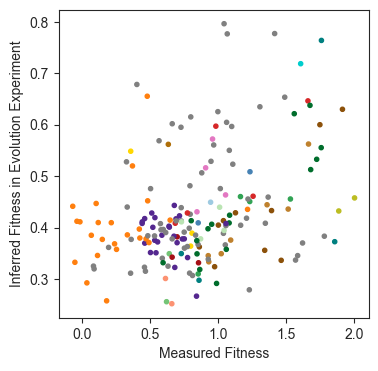

In [169]:
colors = [tools.find_mutation_color(gene) for gene in set_to_plot['gene'].values]
# edge_colors = [tools.anc_color_map[ancestor] for ancestor in set_to_plot['ancestor'].values]


a=np.ma.masked_invalid(set_to_plot['Fit2D_early_fitness_relative'].values)
b=np.ma.masked_invalid(8*set_to_plot['evolution_fitness'].values)

msk = (~a.mask & ~b.mask)

# print(np.ma.corrcoef(a[msk],b[msk]))

a=np.ma.masked_invalid(set_to_plot['Fit2D_both2%5%_fitness_relative'].values)
b=np.ma.masked_invalid(8*set_to_plot['evolution_fitness'].values)

msk = (~a.mask & ~b.mask)

print(np.ma.corrcoef(a[msk],b[msk]))

# print(msk)

# print(np.corrcoef(np.array([set_to_plot['Fit2D_early_fitness_relative'].values,8*set_to_plot['evolution_fitness'].values])))



fig,axs = plt.subplots(ncols=1,figsize=(4,4))

plt.scatter(set_to_plot['Fit2D_early_fitness_relative'].values,
            8*set_to_plot['evolution_fitness'].values,
            c=colors,marker='.')

plt.xlabel('Measured Fitness')
plt.ylabel('Inferred Fitness in Evolution Experiment')
# plt.ylim(0,1) 
# plt.ylim(0,1)

# axs[0].plot([0,2],[0,2],'k--')
# axs[1].scatter(set_to_plot['Fit2D_both2%5%_fitness_relative'].values,8*set_to_plot['evolution_fitness'].values,c=colors)
# axs[1].plot([0,1],[0,1],'k--')
# plt.ylim(0,1)

In [170]:
indices_to_keep = np.argwhere(~np.isnan(set_to_plot['evolution_fitness'].values))

In [171]:
colors = [matplotlib.colors.to_hex(tools.find_mutation_color(gene)) for gene in set_to_plot['gene'].values]

In [172]:
colors

['#808080',
 '#bcbd22',
 '#d62728',
 '#4682b4',
 '#808080',
 '#8c510a',
 '#808080',
 '#00cdcd',
 '#bf812d',
 '#006d2c',
 '#8c510a',
 '#ffd700',
 '#008080',
 '#808080',
 '#31a354',
 '#006d2c',
 '#808080',
 '#008080',
 '#808080',
 '#808080',
 '#808080',
 '#d62728',
 '#006d2c',
 '#e377c2',
 '#ff7f0e',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#ff7f0e',
 '#808080',
 '#8c510a',
 '#808080',
 '#54278f',
 '#006d2c',
 '#808080',
 '#808080',
 '#808080',
 '#ffd700',
 '#4682b4',
 '#8c510a',
 '#808080',
 '#8c510a',
 '#8c510a',
 '#8c510a',
 '#006d2c',
 '#808080',
 '#bcbd22',
 '#006d2c',
 '#d62728',
 '#54278f',
 '#8c510a',
 '#808080',
 '#808080',
 '#808080',
 '#808080',
 '#006d2c',
 '#ff7f0e',
 '#bf812d',
 '#54278f',
 '#bf812d',
 '#ff7f0e',
 '#ff7f0e',
 '#808080',
 '#d62728',
 '#e377c2',
 '#808080',
 '#ff7f0e',
 '#808080',
 '#31a354',
 '#808080',
 '#808080',
 '#808080',
 '#d62728',
 '#54278f',
 '#54278f',
 '#bf812d',
 '#af6f09',
 '#a50f15',
 '#bae4b3',
 '#808080',
 '#808080',
 '#bf812d',
 '#5

       names          coef        se             T      pval       r2  \
0  Intercept  5.866813e-18  0.000959  6.119190e-15  1.000000  0.03562   
1         x1  2.180019e-01  0.083852  2.599843e+00  0.010088  0.03562   

    adj_r2  CI[2.5%]  CI[97.5%]  
0  0.03035 -0.001892   0.001892  
1  0.03035  0.052561   0.383443  


,n,r,CI95%,p-val
pearson,185,0.037577,"[-0.11, 0.18]",0.612559


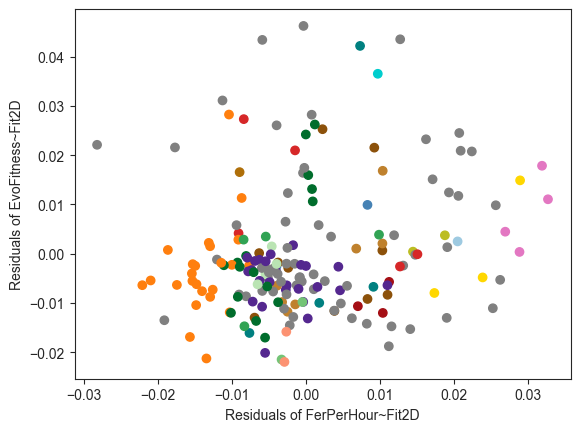

In [173]:

indices_to_keep = np.argwhere(~np.isnan(set_to_plot['evolution_fitness'].values)).flatten()


lr_x = pg.linear_regression(
                            set_to_plot['Fit2D_early_fitness_ancestor'].values[indices_to_keep],
                            set_to_plot['FerPerHour_relative'].values[indices_to_keep],
                            remove_na=True)
lr_y = pg.linear_regression(
                            set_to_plot['Fit2D_early_fitness_ancestor'].values[indices_to_keep],
                            set_to_plot['evolution_fitness'].values[indices_to_keep],
                            remove_na=True)

# lr_x = pg.linear_regression(
#                             set_to_plot['ResPerHour_relative'].values[indices_to_keep],
#                             set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            
#                             remove_na=True)
# lr_y = pg.linear_regression(
#                             set_to_plot['evolution_fitness'].values[indices_to_keep],
#                             set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            
#                             remove_na=True)

plt.scatter(lr_x.residuals_,lr_y.residuals_,c=np.asarray(colors)[indices_to_keep])


lr_partial = pg.linear_regression(lr_x.residuals_,lr_y.residuals_)
print(lr_partial)


plt.xlabel('Residuals of FerPerHour~Fit2D')
plt.ylabel('Residuals of EvoFitness~Fit2D')

pg.partial_corr(data=set_to_plot, x='FerPerHour_relative', y='evolution_fitness', covar=['Fit2D_early_fitness_relative'])





       names          coef        se             T      pval        r2  \
0  Intercept -4.591419e-18  0.000905 -5.071941e-15  1.000000  0.000602   
1         x1 -4.724547e-02  0.142304 -3.320037e-01  0.740266  0.000602   

     adj_r2  CI[2.5%]  CI[97.5%]  
0 -0.004859 -0.001786   0.001786  
1 -0.004859 -0.328013   0.233522  


,n,r,CI95%,p-val
pearson,185,-0.024535,"[-0.17, 0.12]",0.740953


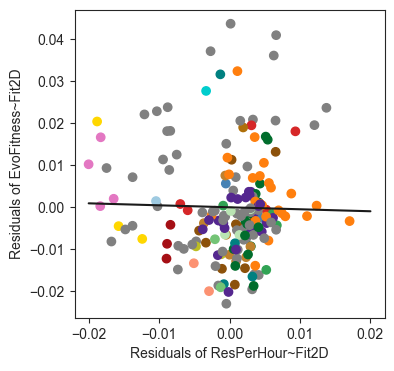

In [177]:

indices_to_keep = np.argwhere(~np.isnan(set_to_plot['evolution_fitness'].values)).flatten()


lr_x = pg.linear_regression(
                            set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            set_to_plot['ResPerHour_relative'].values[indices_to_keep],
                            remove_na=True)
lr_y = pg.linear_regression(
                            set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            set_to_plot['evolution_fitness'].values[indices_to_keep],
                            remove_na=True)

# lr_x = pg.linear_regression(
#                             set_to_plot['ResPerHour_relative'].values[indices_to_keep],
#                             set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            
#                             remove_na=True)
# lr_y = pg.linear_regression(
#                             set_to_plot['evolution_fitness'].values[indices_to_keep],
#                             set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            
#                             remove_na=True)

plt.figure(figsize=(4,4))
plt.scatter(lr_x.residuals_,lr_y.residuals_,c=np.asarray(colors)[indices_to_keep])


lr_partial = pg.linear_regression(lr_x.residuals_,lr_y.residuals_)
print(lr_partial)

xs = np.linspace(-0.02,0.02,100)
plt.plot(xs,lr_partial.coef[0]+lr_partial.coef[1]*xs,color='k')

plt.xlabel('Residuals of ResPerHour~Fit2D')
plt.ylabel('Residuals of EvoFitness~Fit2D')

pg.partial_corr(data=set_to_plot, x='ResPerHour_relative', y='evolution_fitness', covar=['Fit2D_early_fitness_relative'])

# print(partial)


,n,r,CI95%,p-val
pearson,100,-0.040694,"[-0.24, 0.16]",0.689216


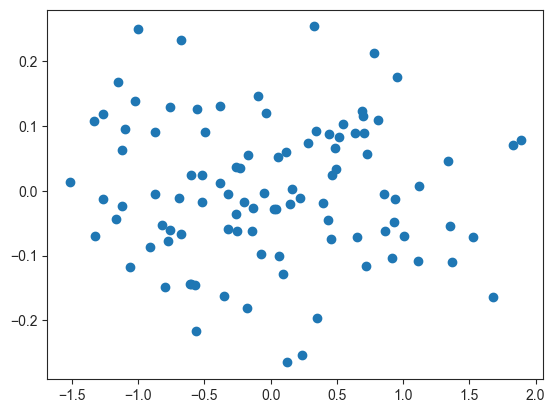

In [23]:
### TESTING PARTIAL CORRELATION LOGIC

R = np.random.normal(size=100)
F = np.random.normal(size=100)

M = R+F+np.random.normal(0,0.01,size=100)
E = 2*R+0.5*F+np.random.normal(0,0.01,size=100)
E = 0.5*R+2*F+np.random.normal(0,0.01,size=100)
E = 10*R+10*F+np.random.normal(0,0.01,size=100)

test_df = p.DataFrame({'M':M,'R':R,'E':E,'F':F})

lr_x = pg.linear_regression(M,R,
                            remove_na=True)
lr_y = pg.linear_regression(M,E,
                            remove_na=True)

plt.scatter(lr_x.residuals_,lr_y.residuals_)


lr_partial = pg.linear_regression(lr_x.residuals_,lr_y.residuals_)
# print(lr_partial)


# plt.xlabel('Residuals of ResPerHour~Fit2D')
# plt.ylabel('Residuals of EvoFitness~Fit2D')

pg.partial_corr(data=test_df, x='R', y='E', covar=['M'])

# # print(partial)



       names       coef        se          T           pval       r2  \
0  Intercept  -0.013710  0.011279  -1.215476   2.257417e-01  0.98374   
1         x1  16.190197  0.361168  44.827288  5.842359e-101  0.98374   
2         x2  28.095277  0.291448  96.399045  1.921391e-159  0.98374   

     adj_r2   CI[2.5%]  CI[97.5%]  
0  0.983563  -0.035963   0.008544  
1  0.983563  15.477633  16.902760  
2  0.983563  27.520268  28.670286  
       names      coef        se         T      pval        r2    adj_r2  \
0  Intercept  0.273735  0.054916  4.984583  0.000001  0.085001  0.075055   
1         x1  2.110692  1.758465  1.200304  0.231564  0.085001  0.075055   
2         x2  5.647281  1.419007  3.979741  0.000099  0.085001  0.075055   

   CI[2.5%]  CI[97.5%]  
0  0.165388   0.382082  
1 -1.358654   5.580039  
2  2.847664   8.446898  
  names       coef        se          T          pval       r2    adj_r2  \
0    x1   0.244608  1.825529   0.133993  8.935538e-01  0.70137  0.698142   
1    x2  1

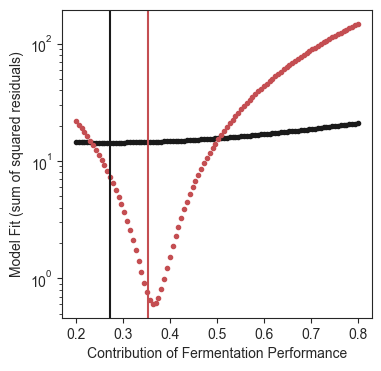

In [138]:
lr_fit2d = pg.linear_regression(
                            np.asarray([set_to_plot['FerPerHour_relative'].values[indices_to_keep],
                                set_to_plot['ResPerHour_relative'].values[indices_to_keep]]).swapaxes(0,1),
                            set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            remove_na=True)

lr_evo = pg.linear_regression(
                            np.asarray([set_to_plot['FerPerHour_relative'].values[indices_to_keep],
                                set_to_plot['ResPerHour_relative'].values[indices_to_keep]]).swapaxes(0,1),
                            8*set_to_plot['evolution_fitness'].values[indices_to_keep],
                            remove_na=True)

lr_evo_nointercept = pg.linear_regression(
                            np.asarray([set_to_plot['FerPerHour_relative'].values[indices_to_keep],
                                set_to_plot['ResPerHour_relative'].values[indices_to_keep]]).swapaxes(0,1),
                            8*set_to_plot['evolution_fitness'].values[indices_to_keep],
                            remove_na=True,add_intercept=False)
print(lr_fit2d)
print(lr_evo)
print(lr_evo_nointercept)

# plt.figure()
# plt.scatter(8*set_to_plot['evolution_fitness'].values[indices_to_keep]/(lr_evo.coef[1]+lr_evo.coef[2]),
#             lr_evo.coef[0]/(lr_evo.coef[1]+lr_evo.coef[1])+
#             lr_evo.coef[1]/(lr_evo.coef[1]+lr_evo.coef[2])*set_to_plot['FerPerHour_relative'].values[indices_to_keep]+
#             lr_evo.coef[2]/(lr_evo.coef[1]+lr_evo.coef[2])*set_to_plot['ResPerHour_relative'].values[indices_to_keep])

# plt.figure()



# fractions = [0.45,0.5,0.55,0.6,0.65,0.7,0.75]
fractions = np.linspace(0.2,0.8,100)

coef_sum = lr_evo.coef[1]+lr_evo.coef[2]

plt.figure(figsize=(4,4))

squared_residuals = []
for fraction in fractions:
    
    estimates = lr_evo.coef[0]+\
            fraction*coef_sum*set_to_plot['FerPerHour_relative'].values[indices_to_keep]+\
            (1-fraction)*coef_sum*set_to_plot['ResPerHour_relative'].values[indices_to_keep]
    
#     plt.subplot(121)
#     plt.scatter(8*set_to_plot['evolution_fitness'].values[indices_to_keep],
#                 estimates
#             ,label=fraction,alpha=0.4)
    
#     plt.subplot(122),marker='.'
    plt.scatter(fraction,np.sum((8*set_to_plot['evolution_fitness'].values[indices_to_keep]-estimates)**2),color='k',marker='.')
    
    squared_residuals.append(np.sum((8*set_to_plot['evolution_fitness'].values[indices_to_keep]-estimates)**2))
    
plt.axvline(fractions[np.where(squared_residuals==np.min(squared_residuals))],color='k')
    
coef_sum = lr_fit2d.coef[1]+lr_fit2d.coef[2]
for fraction in fractions:
#     plt.subplot(122)
    estimates = lr_fit2d.coef[0]+\
            fraction*coef_sum*set_to_plot['FerPerHour_relative'].values[indices_to_keep]+\
            (1-fraction)*coef_sum*set_to_plot['ResPerHour_relative'].values[indices_to_keep]
    plt.scatter(fraction,np.sum((set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep]-estimates)**2),color='r',marker='.')

plt.yscale('log')
# plt.legend()
plt.xlabel('Contribution of Fermentation Performance')
plt.ylabel('Model Fit (sum of squared residuals)')

plt.axvline(17/48,color='r')


# plt.figure(figsize=(12,4))
# plt.subplot(121)
# plt.scatter(set_to_plot['FerPerHour_relative'].values[indices_to_keep],
#             8*set_to_plot['evolution_fitness'].values[indices_to_keep]
#            )
# plt.subplot(122)
# plt.scatter(set_to_plot['ResPerHour_relative'].values[indices_to_keep],
#             8*set_to_plot['evolution_fitness'].values[indices_to_keep]
#            )
# plt.subplot(123)
# plt.scatter(set_to_plot['ResPerHour_relative'].values[indices_to_keep],
#             8*set_to_plot['evolution_fitness'].values[indices_to_keep]
#            )

       names      coef        se         T      pval        r2    adj_r2  \
0  Intercept -0.000656  0.001723 -0.381013  0.703648  0.000947 -0.004666   
1         x1  0.019699  0.047957  0.410772  0.681734  0.000947 -0.004666   

   CI[2.5%]  CI[97.5%]  
0 -0.004056   0.002743  
1 -0.074938   0.114336  


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_80659/2834578954.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(set_to_plot['ResPerHour_relative'].values[indices_to_keep],lr_y.residuals_,c=np.asarray(colors)[indices_to_keep])


,n,r,CI95%,p-val
pearson,180,0.063843,"[-0.08, 0.21]",0.395859


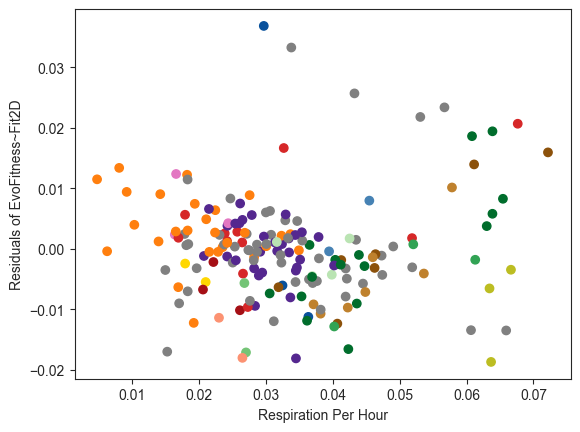

In [55]:

indices_to_keep = np.argwhere(~np.isnan(set_to_plot['evolution_fitness'].values)).flatten()


# lr_x = pg.linear_regression(
#                             set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
#                             set_to_plot['ResPerHour_relative'].values[indices_to_keep],
#                             remove_na=True)
lr_y = pg.linear_regression(
                            set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            set_to_plot['evolution_fitness'].values[indices_to_keep],
                            remove_na=True)

# lr_x = pg.linear_regression(
#                             set_to_plot['ResPerHour_relative'].values[indices_to_keep],
#                             set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            
#                             remove_na=True)
# lr_y = pg.linear_regression(
#                             set_to_plot['evolution_fitness'].values[indices_to_keep],
#                             set_to_plot['Fit2D_early_fitness_relative'].values[indices_to_keep],
                            
#                             remove_na=True)

plt.scatter(set_to_plot['ResPerHour_relative'].values[indices_to_keep],lr_y.residuals_,c=np.asarray(colors)[indices_to_keep])


lr_partial = pg.linear_regression(set_to_plot['ResPerHour_relative'].values[indices_to_keep],lr_y.residuals_)
print(lr_partial)


plt.xlabel('Respiration Per Hour')
plt.ylabel('Residuals of EvoFitness~Fit2D')

pg.partial_corr(data=set_to_plot, x='ResPerHour_relative', y='evolution_fitness', covar=['Fit2D_early_fitness_relative'])





In [17]:
pg.partial_corr(data=set_to_plot, x='ResPerHour_relative', y='evolution_fitness', covar=['Fit2D_early_fitness_relative'])

,n,r,CI95%,p-val
pearson,180,0.063843,"[-0.08, 0.21]",0.395859


In [11]:
set_to_plot[['evolution_fitness',fitness+'_relative','Fit2D_both2%5%_fitness_relative','FerPerHour_relative','ResPerHour_relative']].pcorr()

AttributeError: 'DataFrame' object has no attribute 'pcorr'

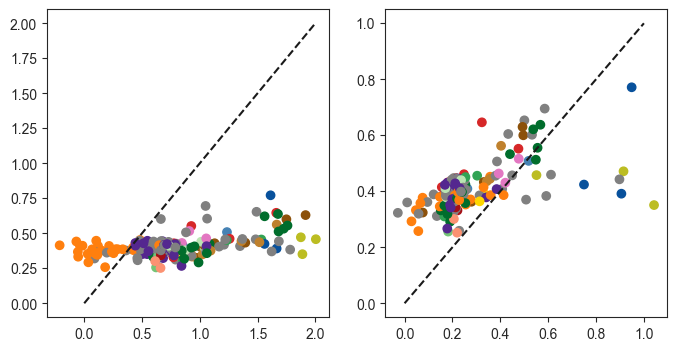

In [22]:
colors = [tools.find_mutation_color(gene) for gene in set_to_plot['gene'].values]

fig,axs = plt.subplots(ncols=2,figsize=(8,4))
axs[0].scatter(set_to_plot['Fit2D_early_fitness_relative'].values,8*set_to_plot['evolution_fitness'].values,c=colors)
axs[0].plot([0,2],[0,2],'k--')
axs[1].scatter(set_to_plot['Fit2D_both2%5%_fitness_relative'].values,8*set_to_plot['evolution_fitness'].values,c=colors)
axs[1].plot([0,1],[0,1],'k--')

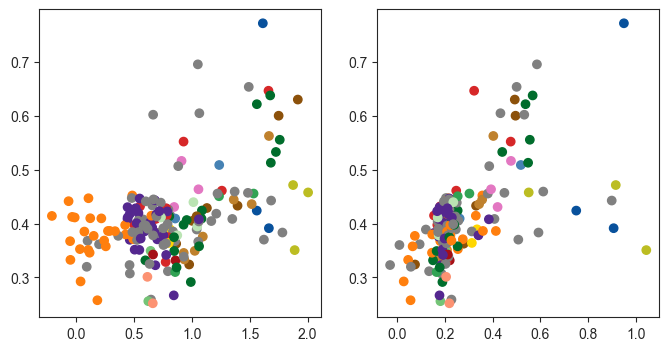

In [21]:
fig,axs = plt.subplots(ncols=2,figsize=(8,4))
axs[0].scatter((set_to_plot['Fit2D_early_fitness']-set_to_plot['Fit2D_early_fitness_ancestor']),8*set_to_plot['evolution_fitness'],c=colors)
axs[1].scatter((set_to_plot['Fit2D_both2%5%_fitness']-set_to_plot['Fit2D_both2%5%_fitness_ancestor']),8*set_to_plot['evolution_fitness'],c=colors)

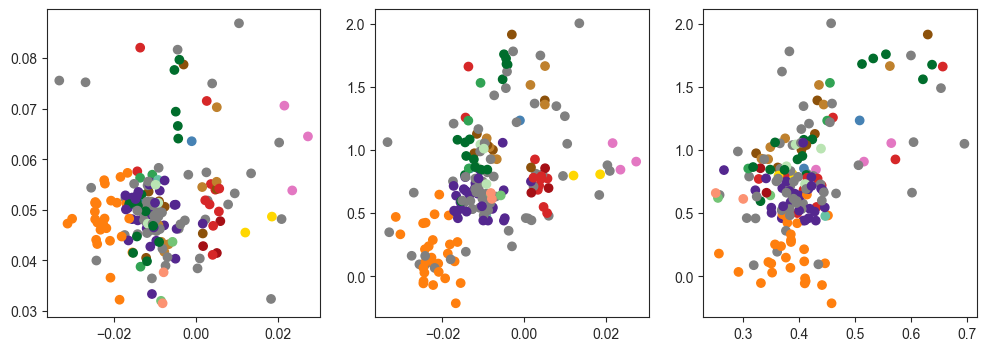

In [247]:
colors = [tools.find_mutation_color(gene) for gene in set_to_plot['gene'].values]

fig,axs = plt.subplots(ncols=3,figsize=(12,4))
axs[0].scatter(set_to_plot['FerPerHour_relative'],set_to_plot['evolution_fitness'],c=colors)

axs[1].scatter(set_to_plot['FerPerHour_relative'],set_to_plot[fitness+'_relative'],c=colors)

axs[2].scatter(8*set_to_plot['evolution_fitness'],set_to_plot[fitness+'_relative'],c=colors)



In [245]:
set_to_plot[['evolution_fitness',fitness+'_relative','FerPerHour_relative','ResPerHour_relative']].pcorr()

,evolution_fitness,Fit2D_early_fitness_relative,FerPerHour_relative,ResPerHour_relative
evolution_fitness,1.000000,-0.053788,0.097927,0.130828
Fit2D_early_fitness_relative,-0.053788,1.000000,0.950879,0.985882
FerPerHour_relative,0.097927,0.950879,1.000000,-0.938205
ResPerHour_relative,0.130828,0.985882,-0.938205,1.000000


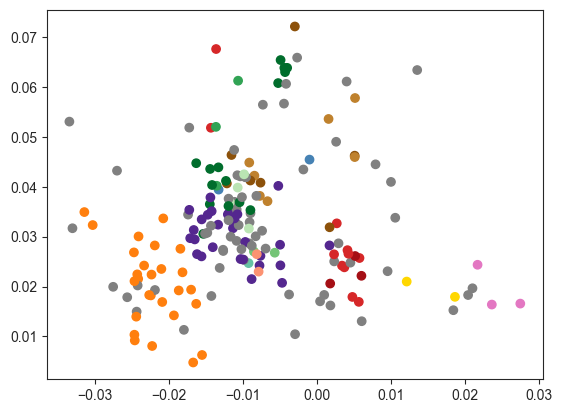

In [307]:
plt.scatter(set_to_plot['FerPerHour_relative'],set_to_plot['ResPerHour_relative'],c=colors)

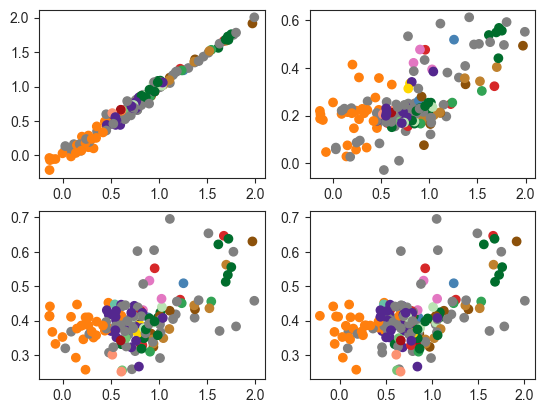

In [309]:
fig,axs = plt.subplots(ncols=2,nrows=2)
axs[0,0].scatter(28*set_to_plot['ResPerHour_relative']+16*set_to_plot['FerPerHour_relative'],
            set_to_plot[fitness+'_relative'],c=colors)

axs[0,1].scatter(28*set_to_plot['ResPerHour_relative']+16*set_to_plot['FerPerHour_relative'],
            set_to_plot['Fit2D_both2%5%_fitness_relative'],c=colors)

axs[1,0].scatter(28*set_to_plot['ResPerHour_relative']+16*set_to_plot['FerPerHour_relative'],
            8*set_to_plot['evolution_fitness'],c=colors)

axs[1,1].scatter(set_to_plot[fitness+'_relative'],
            8*set_to_plot['evolution_fitness'],c=colors)

In [314]:
medium_fitness = set_to_plot[(set_to_plot['Fit2D_early_fitness_relative']>0.75) & (set_to_plot['Fit2D_early_fitness_relative']<1.25)]

,FerPerHour_relative,ResPerHour_relative,evolution_fitness
FerPerHour_relative,1.000000,-0.880477,0.469002
ResPerHour_relative,-0.880477,1.000000,0.416044
evolution_fitness,0.469002,0.416044,1.000000


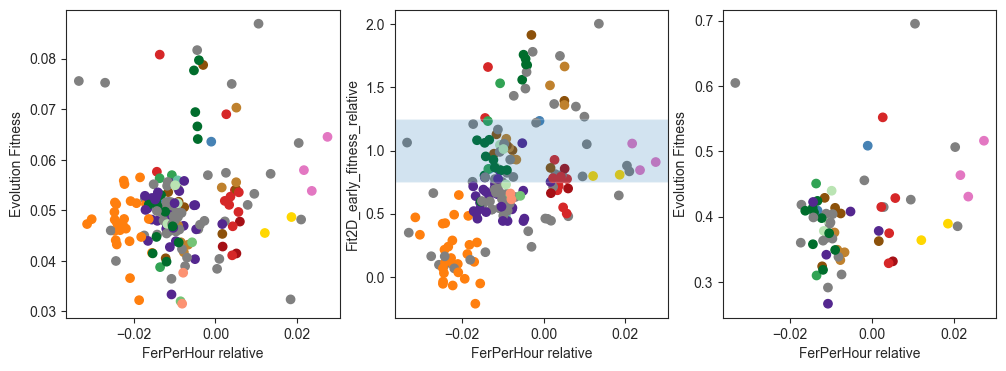

In [330]:

fig,axs=plt.subplots(figsize=(12,4),ncols=3,nrows=1)

colors = [tools.find_mutation_color(gene) for gene in set_to_plot['gene'].values]

axs[0].scatter(set_to_plot['FerPerHour_relative'],set_to_plot['evolution_fitness'],c=colors)
axs[0].set_xlabel('FerPerHour relative')
axs[0].set_ylabel('Evolution Fitness')

axs[1].scatter(set_to_plot['FerPerHour_relative'],set_to_plot[fitness+'_relative'],c=colors)
axs[1].set_xlabel('FerPerHour relative')
axs[1].set_ylabel(fitness+'_relative')

axs[1].axhspan(0.75,1.25,alpha=0.2)



# for f,fitness_interval in [(-0.25,0.25),(0.25,0.75),(0.75,1.25)]
medium_fitness = set_to_plot[(set_to_plot['Fit2D_early_fitness_relative']>0.75) & 
                             (set_to_plot['Fit2D_early_fitness_relative']<1.25)]

colors = [tools.find_mutation_color(gene) for gene in medium_fitness['gene'].values]

axs[2].scatter(medium_fitness['FerPerHour_relative'],8*medium_fitness['evolution_fitness'],c=colors)

axs[2].set_ylabel('Evolution Fitness')
axs[2].set_xlabel('FerPerHour relative')



medium_fitness[['FerPerHour_relative','ResPerHour_relative','evolution_fitness']].pcorr()